In [15]:
import os
!mkdir datsets/images
!mkdir datsets/models
DATA_DIR = os.path.join(os.getcwd(), 'datasets')
IMAGES_DIR = os.path.join(DATA_DIR, 'images')
MODELS_DIR = os.path.join(DATA_DIR, 'models')
for dir in [DATA_DIR, IMAGES_DIR, MODELS_DIR]:
    if not os.path.exists(dir):
        os.mkdir(dir)

mkdir: cannot create directory ‘datsets/images’: No such file or directory
mkdir: cannot create directory ‘datsets/models’: No such file or directory


In [27]:
!cp ./Tensorflow/models/research/object_detection/test_images/image1.jpg ./datasets/images/
!cp ./Tensorflow/models/research/object_detection/test_images/image2.jpg ./datasets/images/
IMAGE_FILENAMES = ['image1.jpg', 'image2.jpg']

In [22]:
import tarfile
import urllib.request
# Download and extract model
MODEL_DATE = '20200711'
MODEL_NAME = 'ssd_mobilenet_v2_320x320_coco17_tpu-8'
MODEL_TAR_FILENAME = MODEL_NAME + '.tar.gz'
MODELS_DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/tf2/'
MODEL_DOWNLOAD_LINK = MODELS_DOWNLOAD_BASE + MODEL_DATE + '/' + MODEL_TAR_FILENAME
PATH_TO_MODEL_TAR = os.path.join(MODELS_DIR, MODEL_TAR_FILENAME)
PATH_TO_CKPT = os.path.join(MODELS_DIR, os.path.join(MODEL_NAME, 'checkpoint/'))
PATH_TO_CFG = os.path.join(MODELS_DIR, os.path.join(MODEL_NAME, 'pipeline.config'))
if not os.path.exists(PATH_TO_CKPT):
    print('Downloading model. This may take a while... ', end='')
    urllib.request.urlretrieve(MODEL_DOWNLOAD_LINK, PATH_TO_MODEL_TAR)
    tar_file = tarfile.open(PATH_TO_MODEL_TAR)
    tar_file.extractall(MODELS_DIR)
    tar_file.close()
    os.remove(PATH_TO_MODEL_TAR)
    print('Done')

# Download labels file
LABEL_FILENAME = 'mscoco_label_map.pbtxt'
LABELS_DOWNLOAD_BASE = \
    'https://raw.githubusercontent.com/tensorflow/models/master/research/object_detection/data/'
PATH_TO_LABELS = os.path.join(MODELS_DIR, os.path.join(MODEL_NAME, LABEL_FILENAME))

if not os.path.exists(PATH_TO_LABELS):
    print('Downloading label file... ', end='')
    !cp ./Tensorflow/models/research/object_detection/data/mscoco_label_map.pbtxt $PATH_TO_LABELS
    print('Done')

In [23]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'    # Suppress TensorFlow logging (1)
import tensorflow as tf
from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder

tf.get_logger().setLevel('ERROR')           # Suppress TensorFlow logging (2)

# Enable GPU dynamic memory allocation
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

# Load pipeline config and build a detection model
configs = config_util.get_configs_from_pipeline_file(PATH_TO_CFG)
model_config = configs['model']
detection_model = model_builder.build(model_config=model_config, is_training=False)

# Restore checkpoint
ckpt = tf.compat.v2.train.Checkpoint(
      model=detection_model)
ckpt.restore(os.path.join(PATH_TO_CKPT, 'ckpt-0')).expect_partial()

@tf.function
def detect_fn(image):
    """Detect objects in image."""

    image, shapes = detection_model.preprocess(image)
    prediction_dict = detection_model.predict(image, shapes)
    detections = detection_model.postprocess(prediction_dict, shapes)

    return detections, prediction_dict, tf.reshape(shapes, [-1])

In [24]:
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS,
                                                                    use_display_name=True)

['image1.jpg', 'image2.jpg']
Running inference for image1.jpg... Done
Running inference for image2.jpg... Done


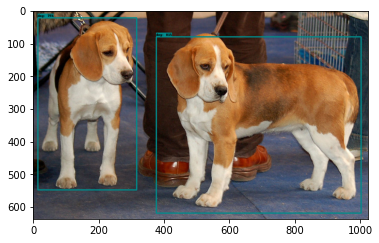

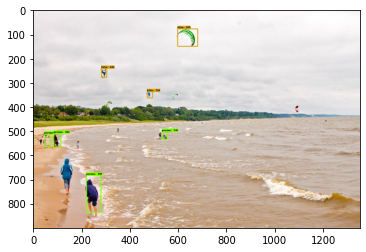

In [42]:
import numpy as np
from six import BytesIO
from PIL import Image
import matplotlib.pyplot as plt
import warnings
%matplotlib inline
warnings.filterwarnings('ignore')   # Suppress Matplotlib warnings

def load_image_into_numpy_array(path):
    """Load an image from file into a numpy array.

    Puts image into numpy array to feed into tensorflow graph.
    Note that by convention we put it into a numpy array with shape
    (height, width, channels), where channels=3 for RGB.

    Args:
      path: the file path to the image

    Returns:
      uint8 numpy array with shape (img_height, img_width, 3)
    """
    img_data = tf.io.gfile.GFile(path, 'rb').read()
    image = Image.open(BytesIO(img_data))
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape(
        (im_height, im_width, 3)).astype(np.uint8)

print(IMAGE_FILENAMES)
for image_filename in IMAGE_FILENAMES:

    print('Running inference for {}... '.format(image_filename), end='')

    image_path = os.path.join(IMAGES_DIR, image_filename)
    image_np = load_image_into_numpy_array(image_path)

    # Things to try:
    # Flip horizontally
    # image_np = np.fliplr(image_np).copy()

    # Convert image to grayscale
    # image_np = np.tile(
    #     np.mean(image_np, 2, keepdims=True), (1, 1, 3)).astype(np.uint8)

    input_tensor = tf.convert_to_tensor(
        np.expand_dims(image_np, 0), dtype=tf.float32)
    detections, predictions_dict, shapes = detect_fn(input_tensor)

    label_id_offset = 1
    image_np_with_detections = image_np.copy()

    viz_utils.visualize_boxes_and_labels_on_image_array(
          image_np_with_detections,
          detections['detection_boxes'][0].numpy(),
          (detections['detection_classes'][0].numpy() + label_id_offset).astype(int),
          detections['detection_scores'][0].numpy(),
          category_index,
          use_normalized_coordinates=True,
          max_boxes_to_draw=200,
          min_score_thresh=.60,
          agnostic_mode=False)
    
    plt.figure()
    
    plt.imshow(image_np_with_detections)
    print('Done')
plt.show()

# sphinx_gallery_thumbnail_number = 2